<a href="https://colab.research.google.com/github/acharyaanusha/Short-Projects/blob/main/Stock_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
#Sequential for initializing the nueral network layer
from keras.models import Sequential
#Dense = adding a densely connected neural network layer
#LSTM = adding the Long Short-Term Memory Layer
#Dropout = dropout layers that prevent overfitting
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

Read the Dataset


In [2]:
from google.colab import files
uploaded = files.upload()

Saving NSE-Tata-Global-Beverages-Limited.csv to NSE-Tata-Global-Beverages-Limited (1).csv


In [3]:
import io

df = pd.read_csv(io.BytesIO(uploaded['NSE-Tata-Global-Beverages-Limited.csv']))
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Analyze the closing prices from dataframe

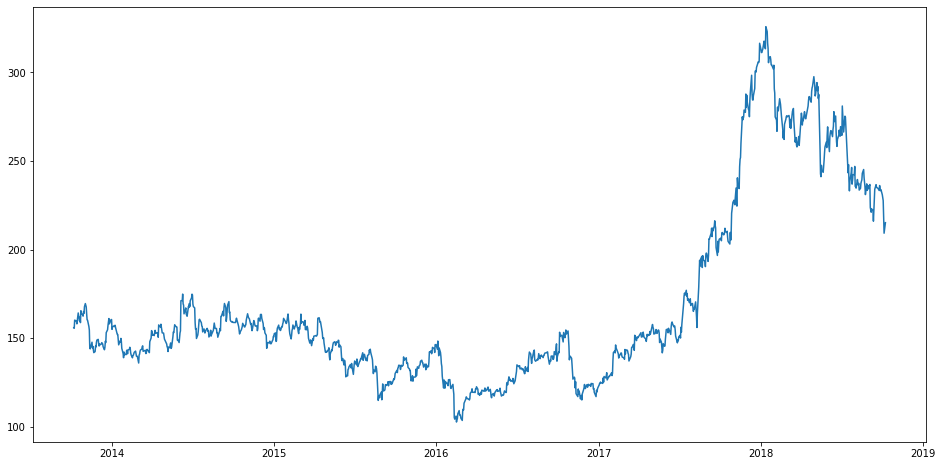

In [4]:
#Convert string Date time into Python Date time object
df['Date']=pd.to_datetime(df.Date,format='%Y-%m-%d')
#Indexing a dataframe to retrive rows and columns by position
df.index = df['Date']

#Create a figure object
plt.figure(figsize=(16,8))
#Plot the figure in 2D
plt.plot(df['Close'],label='Close Price history')

Sort the Dataset on date time and filter 'Date' and 'Close' columns

In [5]:
#Sort the  objects by lables along the given axis
data = df.sort_index(ascending=True,axis=0)

new_dataset = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(len(data)):
  new_dataset['Date'][i]=data['Date'][i]
  new_dataset['Close'][i]=data['Close'][i]

Normalize the new filtered Dataset

In [6]:
new_dataset.index = new_dataset.Date
new_dataset.drop('Date',axis=1,inplace = True)
final_dataset = new_dataset.values

train_data = final_dataset[0:987,:]
valid_data = final_dataset[987:,:]

#Transform feature by scaling each feature to a given range
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)
#LSTM expects data to be in 3D array format
x_train_data,y_train_data=[],[]
#We create data in 60 timesteps and convert it into a numpy array
for i in range(60,len(train_data)):
  x_train_data.append(scaled_data[i-60:i,0])
  y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
#Convert the data into a 3D array with X_train sample, 60 timestamps and one feature at each step
x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

Build and Train the LSTM Model

In [7]:
#LSTM = Long Short-Term Memory layer

lstm_model = Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
#0.2 means that 20% of the layers will be dropped
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

927/927 - 42s - loss: 0.0014


Take a sample of a dataset to make stock price predictions using the LSTM model

In [8]:
X_test = []
for i in range(60,inputs_data.shape[0]):
  X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price = lstm_model.predict(X_test)
#After making the predictions we use inverse_transform to get back the stock prices in normal readable format
closing_price = scaler.inverse_transform(closing_price)

Save the model

In [9]:
lstm_model.save('saved_model.h5')

Visualize the predicted stock costs with actual stock costs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


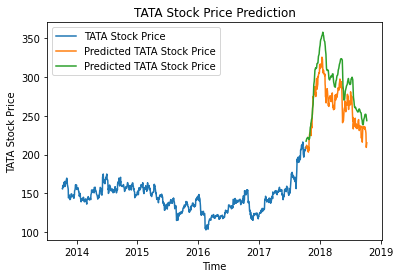

In [13]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data['Close'],label='TATA Stock Price')
plt.plot(valid_data[['Close','Predictions']], label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()